In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from itertools import compress


In [2]:
#load data with xarray
file_path = r"d:\klein\SHYFEM_model_converter\shy.nc"
xr_file = xr.open_dataset(file_path)
print(xr_file)

<xarray.Dataset> Size: 41MB
Dimensions:        (element: 428690, vertex: 3, node: 223415, level: 8, time: 1)
Coordinates:
  * level          (level) float64 64B 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0
  * time           (time) datetime64[ns] 8B 2018-01-01T13:00:00
Dimensions without coordinates: element, vertex, node
Data variables:
    element_index  (element, vertex) int32 5MB ...
    latitude       (node) float64 2MB ...
    longitude      (node) float64 2MB ...
    topology       int32 4B ...
    total_depth    (node) float64 2MB ...
    u_velocity     (time, node, level) float64 14MB ...
    v_velocity     (time, node, level) float64 14MB ...
    water_level    (time, node) float64 2MB ...
Attributes:
    Conventions:  CF-1.4
    title:        venice
    history:      Tue Jan 23 15:06:14 2024: ncks -d time,12 venice_mpi72.ous....
    institution:  ISMAR-CNR, Venice, Italy
    source:       Model data produced by SHYFEM at ISMAR-CNR
    references:   Model info: http://www.ismar.cnr

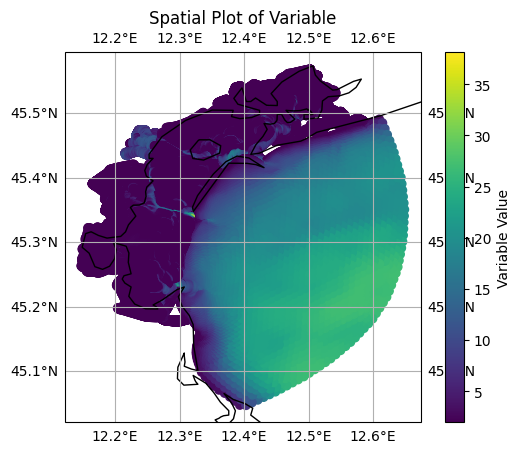

In [3]:
#plot grid
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

var = xr_file['total_depth']
lat = xr_file['latitude']
lon = xr_file['longitude']

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
scatter = ax.scatter(lon, lat, c=var, cmap='viridis', marker='o', transform=ccrs.PlateCarree())
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', label='Variable Value')

ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_title('Spatial Plot of Variable')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

In [4]:
#select area
def row_in_list(row, check_set):
    '''
    Function to asses if all values of row are in list, ignoring nan's
    '''
    row_non_nan = row.dropna().tolist()
    return all(item in check_set for item in row_non_nan)

#Subset on bounding box
bool_nodes_needed = (xr_file['latitude'] >= 45.3) & (xr_file['latitude'] <= 45.4) &\
    (xr_file['longitude'] >= 12.3)  & (xr_file['longitude'] <= 12.4) 
#index_nodes_needed = [i for i, x in enumerate(bool_nodes_needed) if x]
index_nodes_needed = set(list(compress(range(len(bool_nodes_needed)), bool_nodes_needed)))

#create dataframe for selection
face_nodes_dataframe = pd.DataFrame(xr_file.element_index.data)
face_nodes_dataframe = face_nodes_dataframe.replace(-1,np.NaN)

#Get the faces that are needed
faces_needed = face_nodes_dataframe.apply(lambda row : row_in_list(row,index_nodes_needed), axis = 1)
faces_needed = list(faces_needed[faces_needed==True].index.values)

#filter on nodes from dataset data
sub_file = xr_file.sel(node = xr_file.node.isin(list(index_nodes_needed)))

#filter on faces from dataset data
sub_file = sub_file.sel(element = xr_file.element.isin(faces_needed))

#renumber nodes needed
ar = sub_file.element_index.data
k = np.array([k for k in sorted(list(index_nodes_needed))]) 
v = np.array(range(0,len(index_nodes_needed)))

#replace
copy_data = sub_file.element_index.data.copy()
check_copy_data = sub_file.element_index.data.copy()
for key, value in zip(k,v):
    copy_data[sub_file.element_index.data == key] = value

#reset to non-existing cells to -1
copy_data[np.isnan(copy_data)] = -1
copy_data[copy_data < 1.0] = -1

#replace with the corrected data
sub_file.element_index.data = copy_data

#drop fill value attribute
#sub_file.latitude.attrs["_FillValue"] = np.NaN
#sub_file.latitude.attrs["_FillValue"] = np.NaN
#sub_file.longitude.attrs["_FillValue"] = np.NaN
#sub_file.level.attrs["_FillValue"] = False
#sub_file.time.attrs["_FillValue"] = False
#sub_file.total_depth.attrs["_FillValue"] = False

#Check
print(index_nodes_needed)
print(sub_file)


{98304, 98305, 98306, 98307, 98308, 98309, 98310, 98311, 98312, 98313, 98314, 98315, 98316, 98317, 98318, 98319, 98320, 98321, 98322, 98323, 98324, 98325, 98326, 98327, 98328, 98329, 98330, 98331, 98332, 98333, 98334, 98335, 98336, 98337, 98338, 98339, 98340, 98341, 98342, 98343, 98344, 98345, 98346, 98347, 98348, 98349, 98350, 98351, 98352, 98353, 98354, 98355, 98356, 98357, 98358, 98359, 98360, 98361, 98362, 98363, 98364, 98365, 98366, 98367, 140204, 127388, 146926, 138073, 138074, 138075, 138076, 98518, 98519, 98520, 98521, 98522, 98523, 98524, 98525, 98526, 98527, 98528, 98529, 98530, 98531, 98532, 98533, 98534, 98535, 98536, 138077, 98543, 98544, 98545, 98546, 98547, 98548, 98549, 123794, 123795, 98558, 98559, 98561, 98562, 98563, 98564, 123796, 123797, 123798, 123799, 123800, 123801, 123802, 123803, 123804, 123805, 123806, 123807, 130320, 123808, 130321, 131391, 131392, 131393, 123809, 130322, 131396, 131397, 131398, 123810, 130323, 131399, 131400, 131401, 123811, 130324, 131402,

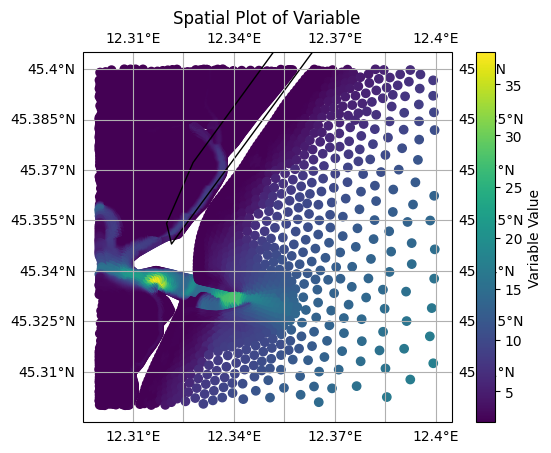

In [5]:
#plot grid
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

var = sub_file['total_depth']
lat = sub_file['latitude']
lon = sub_file['longitude']

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
scatter = ax.scatter(lon, lat, c=var, cmap='viridis', marker='o', transform=ccrs.PlateCarree())
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', label='Variable Value')

ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_title('Spatial Plot of Variable')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


plt.show()

In [6]:
#write to file example
sub_file.to_netcdf("rawdata/shyfem_output_example.nc")